# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)


4.1 Answer: Coverage slows down because with more exploration, we find new, but rare words. Rare words according to coverage formula give small impact.

4.2 Answer: Heaps' Law (from the 1st lecture, 56th slide). 

6671


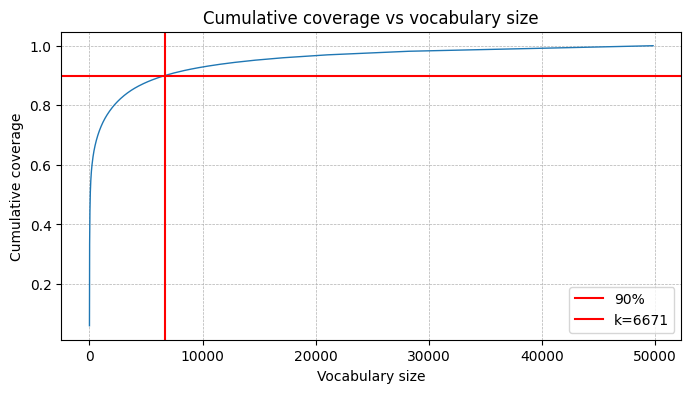

In [15]:
import nltk
nltk.download('brown', quiet=True)
from nltk.corpus import brown
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

words = [w.lower() for w in brown.words()]
freq = Counter(words)

total_tokens = sum(freq.values())

sorted_freq = np.array(sorted(freq.values(), reverse=True))

cumulative = np.cumsum(sorted_freq) / total_tokens
k_90 = int(np.searchsorted(cumulative, 0.9) + 1)

print(k_90)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(cumulative) + 1), cumulative, lw=1)
plt.xlabel('Vocabulary size')
plt.ylabel('Cumulative coverage')
plt.title('Cumulative coverage vs vocabulary size')
plt.axhline(0.9, color='red', linestyle='-', label='90%')
plt.axvline(k_90, color='red', linestyle='-', label=f'k={k_90}')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [ ]:
from collections import Counter


class BPETokenizer:
    """Byte Pair Encoding tokenizer"""

    def __init__(self):
        self.merges = []

    def train(self, words, vocab_size=10000):
        """learn BPE using list of words

        Args:
            words: list of words
            vocab_size: target vocabulary size
        """
        # count word frequencies and split
        freq = Counter(words)
        tokens = {tuple(w) + ('</w>',): f for w, f in freq.items()}

        # initial vocab = characters
        vocab = {s for w in tokens for s in w}

        while len(vocab) < vocab_size:
            # count frequency of joined pairs (like "ap", "pp" from apple)
            pairs = Counter()
            for word, f in tokens.items():
                for pair in zip(word, word[1:]):
                    pairs[pair] += f

            if not pairs:
                break

            # find most frequent pair
            best = max(pairs, key=pairs.get)
            self.merges.append(best)

            # merge best pair in all words
            a, b = best
            merged = a + b
            new_tokens = {}
            for word, f in tokens.items():
                new_word = []
                i = 0
                while i < len(word):
                    if i < len(word) - 1 and word[i] == a and word[i + 1] == b:
                        new_word.append(merged)
                        i += 2
                    else:
                        new_word.append(word[i])
                        i += 1
                new_tokens[tuple(new_word)] = f

            tokens = new_tokens
            vocab.add(merged)

    def tokenize(self, word):
        """tokenize a single word

        Args:
            word: a string to tokenize

        Returns:
            list of subword tokens
        """
        # split into characters + end marker
        symbols = list(word) + ['</w>']

        # apply merges in learned order
        for a, b in self.merges:
            merged = a + b
            new = []
            i = 0
            while i < len(symbols):
                if i < len(symbols) - 1 and symbols[i] == a and symbols[i + 1] == b:
                    new.append(merged)
                    i += 2
                else:
                    new.append(symbols[i])
                    i += 1
            symbols = new

        # remove end marker
        if symbols and symbols[-1].endswith('</w>'):
            symbols[-1] = symbols[-1][:-4]
            if not symbols[-1]:
                symbols.pop()

        return symbols

## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [16]:
import random
import numpy as np
from nltk.corpus import brown

train_words = [w.lower() for w in brown.words()]

target_vocab_size = k_90

tokenizer = BPETokenizer()
tokenizer.train(train_words, vocab_size=target_vocab_size)

sents = list(brown.sents())
random.seed(42)
sample_sents = random.sample(sents, min(1000, len(sents)))

fertilities = []
tokenized_lengths = []

for sent in sample_sents:
    words = [w.lower() for w in sent]
    tokenized = []
    for w in words:
        tokenized.extend(tokenizer.tokenize(w))

    n_words = len(words)
    n_subwords = len(tokenized)
    tokenized_lengths.append(n_subwords)
    fertilities.append(n_subwords / n_words if n_words > 0 else 0.0)

print("fertility:", np.mean(fertilities), np.std(fertilities))
print("tokenized sentence length:", np.mean(tokenized_lengths), np.std(tokenized_lengths))

fertility: 1.2492590261197385 0.21288814288424576
tokenized sentence length: 25.382 18.01510688283586


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later. 

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.